# ECE559 2021 Milestone 1 : Waveguides

In this milestone, we setup compact model extraction of the low-lying modes of two important waveguides : the strip and rib waveguides. Since the height of silicon (or other material) is typically fixed for a given foundry process, important model parameter dependences are widths and wavelength.

The milestone only required simulations for $\lambda = 1.55\mu m$. However, the simulations can just as easily be repeated at other frequencies. If an actually compact compact model is desired, polynomial fits $n_{eff}(\lambda, w)$ as explained in Ch. 3 and 9 of the textbook can be performed on the returned indices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
from meep import mpb

# Other utilities
import time
from IPython.utils import io

/home/rain/anaconda3/envs/ece558/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/rain/anaconda3/envs/ece558/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/rain/anaconda3/envs/ece558/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/rain/anaconda3/envs/ece558/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Materials parameter check

As explained in the textbook, we can use $n=1.444$ across the C-band for SiO$_2$. For silicon, chromatic dispersion is important. Hence, we use Ch. 3's Lorentz model :

In [2]:
c = 299792458 # m/s

def lorentz_index(wl):
    # Assume wl provided in um
    wl_m = wl*1E-6
    eps = 7.9874
    eps_lorentz = 3.6880
    w0 = 3.9328E15
    return np.sqrt(eps + eps_lorentz*w0**2/(w0**2 - (2*np.pi*c/wl_m)**2))

In [5]:
print(lorentz_index(1.15))
print(lorentz_index(1.8))
print(lorentz_index(1.55))

3.52836777863467
3.457805508272692
3.473430881392349


To compare, I compiled some data from the literature (Handbook of Optical Constants of Solids, Edward D. Palik. Academic Press, Boston, 1985, accessed from https://www.filmetrics.com/refractive-index-database/Si/Silicon)

In [6]:
si_data = np.loadtxt('Si.txt', skiprows=1)

The fit agrees reasonably well with the data : 

Text(0.5, 1.0, 'Silicon')

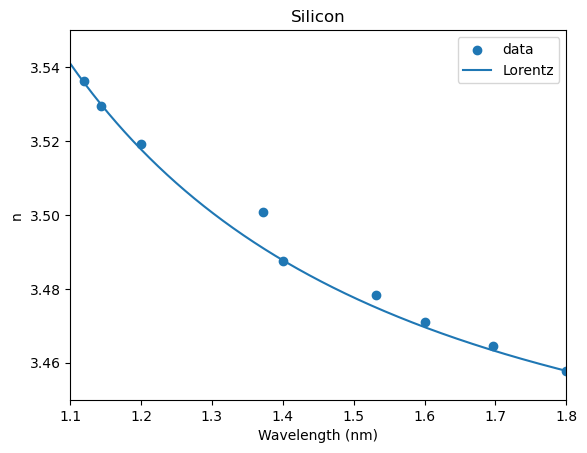

In [7]:
wls = np.linspace(1.100,1.800,1000)

plt.scatter(si_data[:,0]*1E-3, si_data[:,1], label='data')
plt.plot(wls, lorentz_index(wls), label='Lorentz')
plt.xlim([1.100,1.800])
plt.ylim([3.45,3.55])
plt.xlabel('Wavelength (nm)')
plt.ylabel('n')
plt.legend()
plt.title('Silicon')

Text(0.5, 1.0, 'Silicon')

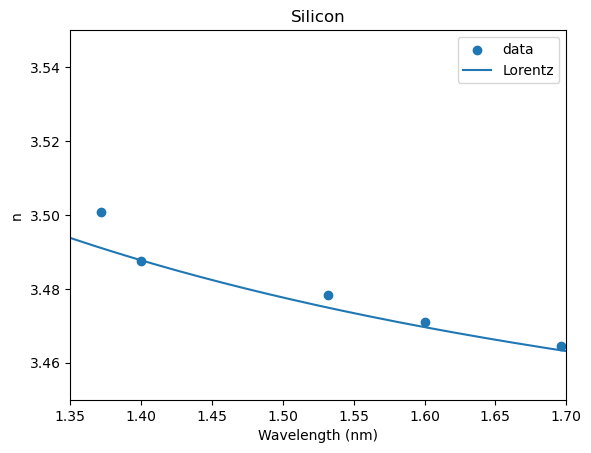

In [8]:
plt.scatter(si_data[:,0]*1E-3, si_data[:,1], label='data')
plt.plot(wls, lorentz_index(wls), label='Lorentz')
plt.xlim([1.35,1.7])
plt.ylim([3.45,3.55])
plt.xlabel('Wavelength (nm)')
plt.ylabel('n')
plt.legend()
plt.title('Silicon')

## Strip waveguide

Let's compute the 4 lowest modes of the strip waveguide as a function of width. This will help us design a single-mode waveguide and understand its dispersion (if we were to repeat the simulation for different wavelengths).\

First, we make sure the situation is setup properly :

In [7]:
#%%capture
wl = 1.55 # args.wl # wavelength (um)
w = 0.8 # waveguide width (um)
sc_y = 4 # supercell width (um)
sc_z = 4 # supercell height (um)
resolution = 32 # simulation resolution (pixels/um)

# Simulation parameters
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# Waveguide definition
h = 0.22  # Si height (um)
Si = mp.Medium(index=lorentz_index(wl)) # Silicon index @ 1550 nm
SiO2 = mp.Medium(index=1.444) # SiO2 index @ 1550 nm
geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h),
                        center=mp.Vector3(), material=Si)]

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution,
    default_material=SiO2)
ms.init_params(mp.NO_PARITY, True)

Working in 3 dimensions.
Grid size is 1 x 128 x 128.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 4, 0)
     (0, 0, 4)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 0.25)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,0.8,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...


Ok, we can use this in our calculation. I will wrap the simulation code in a function so it is easy to call with different parameters later :

In [8]:
def neff_strip(N=1, w=0.5, wl=1.55, h=0.22, sc_y=4, sc_z=4, res=64):
    '''
    Author:        Simon Bilodeau
    Date:          2021-02-07
    Title:         Silicon photonic strip waveguide simulation
    Script returning the first n effective indices of a silicon photonic strip waveguide
    Accounts for material dispersion of the silicon using a Lorentz model
    
    w (float) : width of the waveguide (microns)
    h (float) : heigth of the waveguide (microns)
    wl (float) : wavelength of the simulation (microns)
    n (int) : number of modes to return
    sc_y (float) : width of the simulation (microns)
    sc_z (float) : heigth of the simulation (microns)
    res (int) : resolution of the simulation (pixels/micron)
    '''
    # Simulation parameters
    geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

    # Waveguide definition
    Si = mp.Medium(index=lorentz_index(wl)) # Silicon index @ wl um
    SiO2 = mp.Medium(index=1.444) # SiO2 index @ 1550 nm
    geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h),
                            center=mp.Vector3(), material=Si)]

    # Inverse simulation parameters
    f_mode = 1/wl   # frequency corresponding to desired wavelength (in um) 
    band_min = 1 
    band_max = N
    kdir = mp.Vector3(1) # Our waveguide is along the x direction
    tol = 1e-6 # Iterative solver stop condition
    kmag_guess = f_mode*3.45 # Initial guess
    kmag_min = f_mode*0.1; kmag_max = f_mode*4.0 # Some search range

    # ModeSolver object
    # Some of these are superfluous since we never actually run the forward simulation (e.g. k_points)
    ms = mpb.ModeSolver(
        geometry_lattice=geometry_lattice, # Give it simulation domain
        geometry=geometry, # Give it geometry to simulate
        resolution=res, # Give it discretization level
        default_material=SiO2 # Fully clad by SiO2
        )

    # Do the simulation
    k_fmode = ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
              kmag_min, kmag_max)

    # Compute effective index
    ns_to_return = []
    for i in range(N):
        ns_to_return.append(k_fmode[i] / f_mode)
    
    return ns_to_return

Perform the simulation, selectively suppressing output (since the code is written as to not require it) :

In [9]:
neffs_strip_list = []

start = time.time()
for w in np.linspace(0.2, 0.8, 7):
    start = time.time()
    with io.capture_output() as captured:
        current_neff = neff_strip(N=4, w=w, wl=1.55, h=0.22, sc_y=3, sc_z=3, res=32)
    end = time.time()
    print('w = {0}, neffs = {1}'.format(w, current_neff))
    print('time elapsed = {}'.format(end-start))
    neffs_strip_list.append([w, current_neff])

w = 0.2, neffs = [1.4992494492306003, 1.4801491517897019, 1.4123076297512343, 1.4048279145638234]
time elapsed = 3.341484308242798
w = 0.30000000000000004, neffs = [1.818202759988056, 1.5935749895692242, 1.4307776731022974, 1.4239186336861778]
time elapsed = 3.156452178955078
w = 0.4, neffs = [2.2261413882899497, 1.6933527434961062, 1.4347382439325487, 1.4273747263756904]
time elapsed = 3.3332600593566895
w = 0.5, neffs = [2.440963964199458, 1.7709854406796115, 1.4888886591905148, 1.4365021687425894]
time elapsed = 2.333890914916992
w = 0.6000000000000001, neffs = [2.5685635379833296, 1.8321264282711238, 1.6904266926290312, 1.4384611640982468]
time elapsed = 2.239154100418091
w = 0.7000000000000002, neffs = [2.640125990691125, 1.9534197337041774, 1.875228125596033, 1.4573173678194962]
time elapsed = 1.207439661026001
w = 0.8, neffs = [2.6894279415873004, 2.1660818954808643, 1.9083736294589637, 1.528198119039989]
time elapsed = 1.1791019439697266


I also extracted the data of Fig. 3.18 in te book from the book using WedPlotDigitizer : they are the lines, and the data points are the simulations. The agreement is excellent.

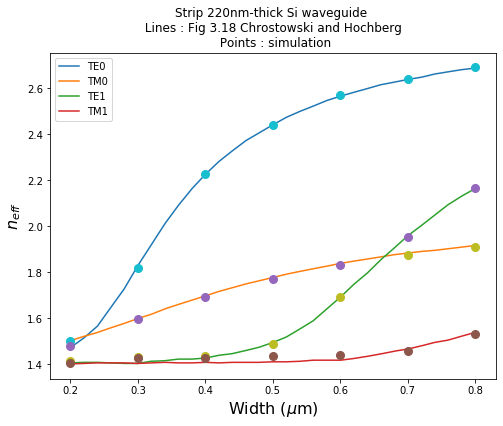

In [10]:
f = plt.figure(figsize=(8, 6))

# I webdigitized the data from the book
strip_book_TE0 = np.loadtxt('chrostowski_strip_TE0.txt', delimiter=',')
strip_book_TE1 = np.loadtxt('chrostowski_strip_TE1.txt', delimiter=',')
strip_book_TM0 = np.loadtxt('chrostowski_strip_TM0.txt', delimiter=',')
strip_book_TM1 = np.loadtxt('chrostowski_strip_TM1.txt', delimiter=',')

plt.plot(strip_book_TE0[:,0]/1000, strip_book_TE0[:,1], label='TE0', color='tab:blue')
plt.plot(strip_book_TM0[:,0]/1000, strip_book_TM0[:,1], label='TM0', color='tab:orange')
plt.plot(strip_book_TE1[:,0]/1000, strip_book_TE1[:,1], label='TE1', color='tab:green')
plt.plot(strip_book_TM1[:,0]/1000, strip_book_TM1[:,1], label='TM1', color='tab:red')

for i in range(7):
    # plotting these the lazy way : could get full curves with array manipulations
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][0], marker='o', markersize=8, color='tab:cyan')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][1], marker='o', markersize=8, color='tab:purple')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][2], marker='o', markersize=8, color='tab:olive')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][3], marker='o', markersize=8, color='tab:brown')

plt.xlabel('Width ($\mu$m)', fontsize=16)
plt.ylabel('$n_{eff}$', fontsize=16)
plt.title('Strip 220nm-thick Si waveguide \n Lines : Fig 3.18 Chrostowski and Hochberg \n Points : simulation')

plt.legend()

If we didn't know the result, we would have to convince ourselves what we are seeing is physics and not numerical artefacts. Let's do it again with a larger supercell to see if we get the same thing : 

In [11]:
neffs_strip_list_4x4 = []

start = time.time()
for w in np.linspace(0.2, 0.8, 7):
    start = time.time()
    with io.capture_output() as captured:
        current_neff = neff_strip(N=4, w=w, wl=1.55, h=0.22, sc_y=4, sc_z=4, res=32)
    end = time.time()
    print('w = {0}, neffs = {1}'.format(w, current_neff))
    print('time elapsed = {}'.format(end-start))
    neffs_strip_list_4x4.append([w, current_neff])

w = 0.2, neffs = [1.4973620143287947, 1.477056984509784, 1.430915802556245, 1.4274262693396154]
time elapsed = 4.514592885971069
w = 0.30000000000000004, neffs = [1.818199186208279, 1.5933832679610314, 1.4379783697918618, 1.4354402841855745]
time elapsed = 3.655369281768799
w = 0.4, neffs = [2.2261403082659412, 1.693323551941566, 1.439553921283655, 1.436709693358675]
time elapsed = 4.69465970993042
w = 0.5, neffs = [2.4409638324733787, 1.7709745664437924, 1.4900924814351488, 1.440302445762748]
time elapsed = 4.0086565017700195
w = 0.6000000000000001, neffs = [2.5685624870840584, 1.8321195190416437, 1.6904528525009028, 1.4411785754714084]
time elapsed = 2.3755252361297607
w = 0.7000000000000002, neffs = [2.6401261832131944, 1.9534195534240817, 1.875221836635829, 1.4604281939444907]
time elapsed = 1.509511947631836
w = 0.8, neffs = [2.689427559746651, 2.1660831651100922, 1.9083678188992839, 1.5289458868609356]
time elapsed = 1.4068622589111328


Text(0.5, 1.0, 'Strip 220nm-thick Si waveguide \n Points : Initial simulation \n Crosses : larger domain simulation')

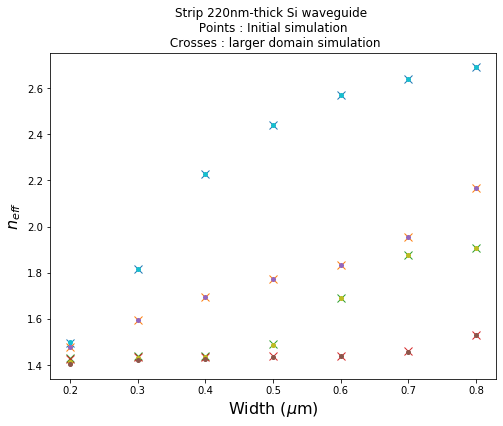

In [12]:
f = plt.figure(figsize=(8, 6))

for i in range(7):
    plt.plot(neffs_strip_list_4x4[i][0], neffs_strip_list_4x4[i][1][0], marker='x', markersize=8, color='tab:blue')
    plt.plot(neffs_strip_list_4x4[i][0], neffs_strip_list_4x4[i][1][1], marker='x', markersize=8, color='tab:orange')
    plt.plot(neffs_strip_list_4x4[i][0], neffs_strip_list_4x4[i][1][2], marker='x', markersize=8, color='tab:green')
    plt.plot(neffs_strip_list_4x4[i][0], neffs_strip_list_4x4[i][1][3], marker='x', markersize=8, color='tab:red')

for i in range(7):
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][0], marker='.', markersize=8, color='tab:cyan')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][1], marker='.', markersize=8, color='tab:purple')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][2], marker='.', markersize=8, color='tab:olive')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][3], marker='.', markersize=8, color='tab:brown')

plt.xlabel('Width ($\mu$m)', fontsize=16)
plt.ylabel('$n_{eff}$', fontsize=16)
plt.title('Strip 220nm-thick Si waveguide \n Points : Initial simulation \n Crosses : larger domain simulation')

In [13]:
neffs_strip_list_res64 = []

start = time.time()
for w in np.linspace(0.2, 0.8, 7):
    start = time.time()
    with io.capture_output() as captured:
        current_neff = neff_strip(N=4, w=w, wl=1.55, h=0.22, sc_y=3, sc_z=3, res=64)
    end = time.time()
    print('w = {0}, neffs = {1}'.format(w, current_neff))
    print('time elapsed = {}'.format(end-start))
    neffs_strip_list_res64.append([w, current_neff])

w = 0.2, neffs = [1.4970894619438382, 1.4821635102034318, 1.4117393190961187, 1.405772585009624]
time elapsed = 29.337844371795654
w = 0.30000000000000004, neffs = [1.8234419721223178, 1.5900651980461773, 1.4308070946884544, 1.423772902237245]
time elapsed = 28.081454515457153
w = 0.4, neffs = [2.2206055105499303, 1.6868017446931434, 1.4346930126589121, 1.4155907550303533]
time elapsed = 20.833866596221924
w = 0.5, neffs = [2.4384527965916867, 1.7655621995195265, 1.4894045913997056, 1.4364741646908705]
time elapsed = 18.903250694274902
w = 0.6000000000000001, neffs = [2.560921448236895, 1.824235798865237, 1.6846782114120615, 1.4384208418427473]
time elapsed = 18.077801942825317
w = 0.7000000000000002, neffs = [2.635375102754075, 1.9526962862909445, 1.8681179963595154, 1.45258520084076]
time elapsed = 9.919869661331177
w = 0.8, neffs = [2.6835966645899374, 2.162498304222329, 1.9008405528561263, 1.522471523625873]
time elapsed = 9.160752534866333


Text(0.5, 1.0, 'Strip 220nm-thick Si waveguide \n Points : Initial simulation \n Crosses : higher resolution simulation')

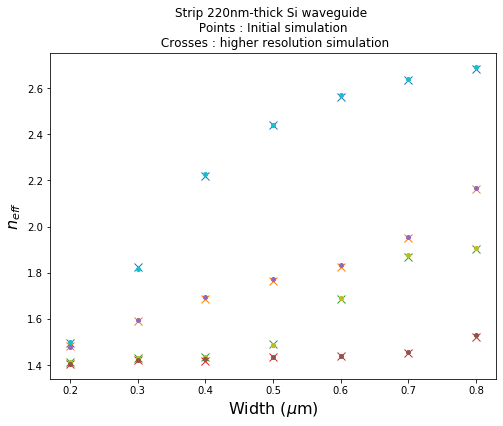

In [14]:
f = plt.figure(figsize=(8, 6))

for i in range(7):
    plt.plot(neffs_strip_list_res64[i][0], neffs_strip_list_res64[i][1][0], marker='x', markersize=8, color='tab:blue')
    plt.plot(neffs_strip_list_res64[i][0], neffs_strip_list_res64[i][1][1], marker='x', markersize=8, color='tab:orange')
    plt.plot(neffs_strip_list_res64[i][0], neffs_strip_list_res64[i][1][2], marker='x', markersize=8, color='tab:green')
    plt.plot(neffs_strip_list_res64[i][0], neffs_strip_list_res64[i][1][3], marker='x', markersize=8, color='tab:red')

for i in range(7):
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][0], marker='.', markersize=8, color='tab:cyan')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][1], marker='.', markersize=8, color='tab:purple')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][2], marker='.', markersize=8, color='tab:olive')
    plt.plot(neffs_strip_list[i][0], neffs_strip_list[i][1][3], marker='.', markersize=8, color='tab:brown')

plt.xlabel('Width ($\mu$m)', fontsize=16)
plt.ylabel('$n_{eff}$', fontsize=16)
plt.title('Strip 220nm-thick Si waveguide \n Points : Initial simulation \n Crosses : higher resolution simulation')

Since both simulation domain and resolution do no affect the results, they are likely physical (provided we have chosen our other parameters such as index correctly!). Looking at the field profiles could further strengthen our conviction. Looking at the fields would also help differentiate between modes of different symmetry, since we only asked MPB to return modes in order of increasing $n_{eff}$.

## Rib waveguide

Quick geometry check : 

In [15]:
wl = 1.55 # args.wl # wavelength (um)
w = 0.7 # waveguide width (um)
sc_y = 4 # np.linspace(1, 6, 11)  # supercell width (um)
sc_z = 4 # np.linspace(1, 6, 11)  # supercell height (um)
resolution = 64 # np.linspace(8,512,20) # args.res # simulation resolution (pixels/um)

# Simulation parameters
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# Waveguide definition
h = 0.22  # Si height (um)
hslab = 0.09
Si = mp.Medium(index=lorentz_index(wl)) # Silicon index @ 1550 nm
SiO2 = mp.Medium(index=1.444) # SiO2 index @ 1550 nm
geometry = [mp.Block(size=mp.Vector3(mp.inf, sc_y, hslab),center=mp.Vector3(0,0,-hslab/2),material=Si),
           mp.Block(size=mp.Vector3(mp.inf,w,h),center=mp.Vector3(0,0,-h/2),material=Si)]

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution,
    default_material=SiO2)
ms.init_params(mp.NO_PARITY, True)

Working in 3 dimensions.
Grid size is 1 x 256 x 256.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 4, 0)
     (0, 0, 4)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 0.25)
Geometric objects:
     block, center = (0,0,-0.045)
          size (1e+20,4,0.09)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.11)
          size (1e+20,0.7,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 5 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...


epsilon: 2.08514-12.0647, mean 2.36655, harm. mean 2.14023, 100% > 1, 2.81985% "fill"


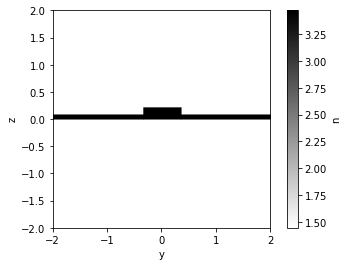

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

n = np.sqrt(ms.get_epsilon())

pos = ax.imshow(n.T, cmap='gray_r', interpolation='spline36', extent=[-sc_y/2,sc_y/2,-sc_z/2,sc_z/2] )
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('n')
ax.set_xlabel('y')
ax.set_ylabel('z')
plt.show()

In [17]:
def neff_rib(N=1, w=0.5, hslab=0.09, wl=1.55, h=0.22, sc_y=4, sc_z=4, res=64):
    '''
    Author:        Simon Bilodeau
    Date:          2021-02-07
    Title:         Silicon photonic rib waveguide simulation
    Script returning the first N effective indices of a silicon photonic rib waveguide
    Accounts for material dispersion of the silicon using a Lorentz model
    
    w (float) : width of the waveguide (microns)
    h (float) : heigth of the waveguide (microns)
    hslab (float) : heigth of the slab (microns)
    wl (float) : wavelength of the simulation (microns)
    N (int) : number of modes to return
    sc_y (float) : width of the simulation (microns)
    sc_z (float) : heigth of the simulation (microns)
    res (int) : resolution of the simulation (pixels/micron)
    '''
    # Simulation parameters
    geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

    # Waveguide definition
    Si = mp.Medium(index=lorentz_index(wl)) # Silicon index @ wl um
    SiO2 = mp.Medium(index=1.444) # SiO2 index @ 1550 nm
    geometry = [mp.Block(size=mp.Vector3(mp.inf, sc_y, hslab),center=mp.Vector3(0,0,-hslab/2),material=Si),
               mp.Block(size=mp.Vector3(mp.inf,w,h),center=mp.Vector3(0,0,-h/2),material=Si)]



    # Inverse simulation parameters
    f_mode = 1/wl   # frequency corresponding to desired wavelength (in um) 
    band_min = 1
    band_max = N
    kdir = mp.Vector3(1) # Our waveguide is along the x direction
    tol = 1e-6 # Iterative solver stop condition
    kmag_guess = f_mode*3.45 # Initial guess
    kmag_min = f_mode*0.1; 
    kmag_max = f_mode*4.0 # Some search range

    # ModeSolver object
    ms = mpb.ModeSolver(
        geometry_lattice=geometry_lattice, # Give it simulation domain
        geometry=geometry, # Give it geometry to simulate
        resolution=res, # Give it discretization level
        default_material=SiO2 # Fully clad by SiO2
        )
    # Do the simulation
    k_fmode = ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
              kmag_min, kmag_max)

    # Compute effective index
    ns_to_return = []
    for i in range(N):
        ns_to_return.append(k_fmode[i] / f_mode)
    
    return ns_to_return

Repeating above, but with only the lowest band : 

In [18]:
neffs_rib_list = []

start = time.time()
for w in np.linspace(0.2, 0.8, 7):
    start = time.time()
    with io.capture_output() as captured:
        current_neff = neff_rib(N=1, w=w, hslab=0.09, wl=1.55, h=0.22, sc_y=3, sc_z=3, res=32)
    end = time.time()
    print('w = {0}, neffs = {1}'.format(w, current_neff))
    print('time elapsed = {}'.format(end-start))
    neffs_rib_list.append([w, current_neff])

w = 0.2, neffs = [2.168255169577652]
time elapsed = 0.18610572814941406
w = 0.30000000000000004, neffs = [2.3155385939051856]
time elapsed = 0.14980864524841309
w = 0.4, neffs = [2.455646622071342]
time elapsed = 0.11785626411437988
w = 0.5, neffs = [2.5517937057587954]
time elapsed = 0.10736441612243652
w = 0.6000000000000001, neffs = [2.624109377749139]
time elapsed = 0.10799241065979004
w = 0.7000000000000002, neffs = [2.6699510356317444]
time elapsed = 0.10424375534057617
w = 0.8, neffs = [2.7054569819367704]
time elapsed = 0.10679459571838379


Comparing to Fig. 3.20 in the book :

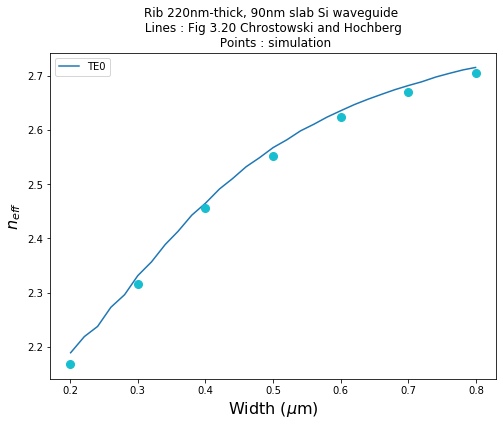

In [19]:
f = plt.figure(figsize=(8, 6))

# I webdigitized the data from the book
rib_book_TE0 = np.loadtxt('chrostowski_rib_TE0.txt', delimiter=',')

plt.plot(rib_book_TE0[:,0]/1000, rib_book_TE0[:,1], label='TE0', color='tab:blue')

for i in range(7):
    plt.plot(neffs_rib_list[i][0], neffs_rib_list[i][1][0], marker='o', markersize=8, color='tab:cyan')

plt.xlabel('Width ($\mu$m)', fontsize=16)
plt.ylabel('$n_{eff}$', fontsize=16)
plt.title('Rib 220nm-thick, 90nm slab Si waveguide \n Lines : Fig 3.20 Chrostowski and Hochberg \n Points : simulation')

plt.legend()

Let's do it again with a larger supercell to see if we get the same thing : 

In [20]:
neffs_rib_list_4x4 = []

start = time.time()
for w in np.linspace(0.2, 0.8, 7):
    start = time.time()
    with io.capture_output() as captured:
        current_neff = neff_rib(N=1, w=w, hslab=0.09, wl=1.55, h=0.22, sc_y=4, sc_z=4, res=32)
    end = time.time()
    print('w = {0}, neffs = {1}'.format(w, current_neff))
    print('time elapsed = {}'.format(end-start))
    neffs_rib_list_4x4.append([w, current_neff])

w = 0.2, neffs = [2.1680028674199256]
time elapsed = 0.28380608558654785
w = 0.30000000000000004, neffs = [2.3155326538648846]
time elapsed = 0.20720934867858887
w = 0.4, neffs = [2.4556458336311215]
time elapsed = 0.1658339500427246
w = 0.5, neffs = [2.553612043010251]
time elapsed = 0.15152835845947266
w = 0.6000000000000001, neffs = [2.6241083241222167]
time elapsed = 0.15356969833374023
w = 0.7000000000000002, neffs = [2.669951120448543]
time elapsed = 0.1520252227783203
w = 0.8, neffs = [2.7054566021122097]
time elapsed = 0.15340375900268555


Text(0.5, 1.0, 'Rib 220nm-thick, 90nm slab Si waveguide \n Points : initial simulation \n Crosses : larger domain simulation')

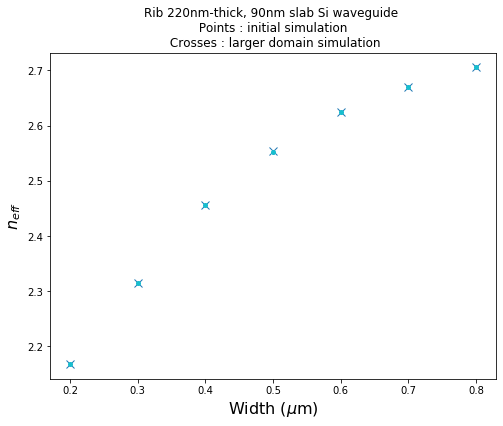

In [21]:
f = plt.figure(figsize=(8, 6))

for i in range(7):
    plt.plot(neffs_rib_list_4x4[i][0], neffs_rib_list_4x4[i][1][0], marker='x', markersize=8, color='tab:blue')

for i in range(7):
    plt.plot(neffs_rib_list[i][0], neffs_rib_list[i][1][0], marker='.', markersize=8, color='tab:cyan')

plt.xlabel('Width ($\mu$m)', fontsize=16)
plt.ylabel('$n_{eff}$', fontsize=16)
plt.title('Rib 220nm-thick, 90nm slab Si waveguide \n Points : initial simulation \n Crosses : larger domain simulation')

In [22]:
neffs_rib_list_res64 = []

start = time.time()
for w in np.linspace(0.2, 0.8, 7):
    start = time.time()
    with io.capture_output() as captured:
        current_neff = neff_rib(N=1, w=w, hslab=0.09, wl=1.55, h=0.22, sc_y=3, sc_z=3, res=64)
    end = time.time()
    print('w = {0}, neffs = {1}'.format(w, current_neff))
    print('time elapsed = {}'.format(end-start))
    neffs_rib_list_res64.append([w, current_neff])

w = 0.2, neffs = [2.183167872228819]
time elapsed = 0.9083149433135986
w = 0.30000000000000004, neffs = [2.322349245677061]
time elapsed = 0.7340319156646729
w = 0.4, neffs = [2.461084322862353]
time elapsed = 0.5539138317108154
w = 0.5, neffs = [2.5618259964021526]
time elapsed = 0.5170562267303467
w = 0.6000000000000001, neffs = [2.631370659932477]
time elapsed = 0.5177490711212158
w = 0.7000000000000002, neffs = [2.6798544379475993]
time elapsed = 0.49411582946777344
w = 0.8, neffs = [2.7133298976438898]
time elapsed = 0.4939248561859131


Text(0.5, 1.0, 'Rib 220nm-thick, 90nm slab Si waveguide \n Lines : Fig 3.20 Chrostowski and Hochberg \n Points : initial simulation \n Crosses : larger resolution simulation')

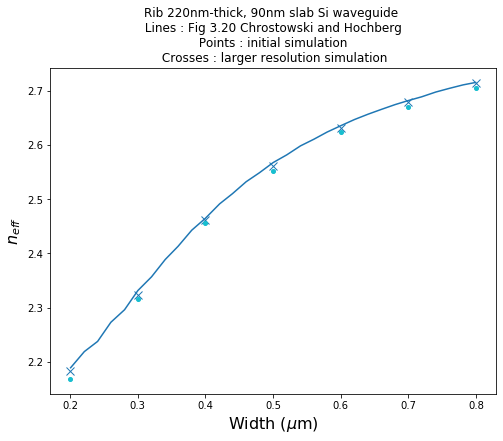

In [23]:
f = plt.figure(figsize=(8, 6))

for i in range(7):
    plt.plot(neffs_rib_list_res64[i][0], neffs_rib_list_res64[i][1][0], marker='x', markersize=8, color='tab:blue')

plt.plot(rib_book_TE0[:,0]/1000, rib_book_TE0[:,1], label='TE0', color='tab:blue')    

for i in range(7):
    plt.plot(neffs_rib_list[i][0], neffs_rib_list[i][1][0], marker='.', markersize=8, color='tab:cyan')

plt.xlabel('Width ($\mu$m)', fontsize=16)
plt.ylabel('$n_{eff}$', fontsize=16)
plt.title('Rib 220nm-thick, 90nm slab Si waveguide \n Lines : Fig 3.20 Chrostowski and Hochberg \n Points : initial simulation \n Crosses : larger resolution simulation')

We see here that our original resolution was not good enough. By increasing it, we match the book more closely. In a real setting, you could sweep the resolution to ever higher values until it stopped changing to convince yourself you were not seeing numerical artefacts.

## Bonus : group index

One thing we mentioned in class is how while in theory the dispersion diagram gives you everything you would want to know about the guided mode, in practice material dispersion means that the eigenmode calculation using the index corresponding to a specific wavelength is only really valid at that wavelength. 

However, we have the ability to repeat the simulation at different wavelengths. Recall the formula for group index : 

$$ n_g = n_{eff}(\lambda) - \lambda \frac{dn_{eff}(\lambda)}{d\lambda} $$

We can estimate the derivative using finite differences to take into account all wavelength dependences of $n_{eff}$ (both waveguide dispersion and material dispersion) :

$$ \frac{dn_{eff}(\lambda)}{d\lambda} \approx \frac{n_{eff}(\lambda + \beta) - n_{eff}(\lambda)}{\beta} $$

We will use $\beta$ as a finite-difference parameter (Lumerical uses such a step parameter as well).

Note : much higher resolution is required to get acceptable accuracy here.

In [24]:
def ng_rib(beta = 0.001, w=0.5, hslab = 0.09, wl=1.55, h=0.22, sc_y=4, sc_z=4, res=32):
    '''
    Author:        Simon Bilodeau
    Date:          2021-02-25
    Title:         Silicon photonic rib waveguide TE0 group index
    Script returning the first group index of a silicon photonic rib waveguide. 
    Uses effective indices at wl and wl + beta to approximate dn/d(wl)
    Accounts for material dispersion of the silicon using a Lorentz model
    
    beta (float) : discretization parameter for the finite difference
    w (float) : width of the waveguide (microns)
    h (float) : heigth of the waveguide (microns)
    hslab (float) : heigth of the slab (microns)
    wl (float) : wavelength of the simulation (microns)
    N (int) : number of modes to return
    sc_y (float) : width of the simulation (microns)
    sc_z (float) : heigth of the simulation (microns)
    res (int) : resolution of the simulation (pixels/micron)
    '''
    
    # Get the effective index at lambda
    n0 = neff_rib(N=1, w=w, hslab=hslab, wl=wl, h=h, sc_y=sc_y, sc_z=sc_z, res=res)
    # Get the effective index at lambda + beta; our neff_rib code has an index for
    # silicon that depends on lambda
    nb = neff_rib(N=1, w=w, hslab=hslab, wl=wl + beta, h=h, sc_y=sc_y, sc_z=sc_z, res=res)
    
    # Return the finite difference
    return n0[0] - wl*(nb[0] - n0[0])/beta

In [25]:
ngs_rib_list = []

start = time.time()
for wl in np.linspace(1.5, 1.6, 11):
    start = time.time()
    with io.capture_output() as captured:
        current_ng = ng_rib(beta = 1E-3, w=0.5, wl=wl, hslab=0.09,  h=0.22, sc_y=4, sc_z=4, res=128)
    end = time.time()
    print('wl = {0}, ng = {1}'.format(wl, current_ng))
    print('time elapsed = {}'.format(end-start))
    ngs_rib_list.append([wl, current_ng])

wl = 1.5, ng = 3.9071500186757633
time elapsed = 26.42553186416626
wl = 1.51, ng = 3.9023975671421836
time elapsed = 27.120503187179565
wl = 1.52, ng = 3.8976057411444796
time elapsed = 25.363730430603027
wl = 1.53, ng = 3.892770787509368
time elapsed = 25.218369483947754
wl = 1.54, ng = 3.8878887830543714
time elapsed = 23.955838918685913
wl = 1.55, ng = 3.8829559401240936
time elapsed = 23.72592520713806
wl = 1.56, ng = 3.877968516464533
time elapsed = 25.560075998306274
wl = 1.57, ng = 3.8729231388005028
time elapsed = 22.81340789794922
wl = 1.58, ng = 3.867816440942819
time elapsed = 24.45631432533264
wl = 1.59, ng = 3.8626450423540377
time elapsed = 24.2313711643219
wl = 1.6, ng = 3.8574056118297118
time elapsed = 23.04471755027771


Convergence w.r.t. $\beta$ should also be checked in addition to `sc` and `res`, if we did not have independent verification.

Let's also compute the "group index" if the index of silicon was fixed to 3.47  (like Fig. 3.21 in Chrostowski and Hochberg) :

In [26]:
def ng_rib_fixedIndex(N=1, w=0.5, hslab=0.09, wl=1.55, h=0.22, nSi = 3.47, sc_y=4, sc_z=4, res=128):
    '''
    Author:        Simon Bilodeau
    Date:          2021-02-25
    Title:         Silicon photonic rib waveguide TE0 group index simulation
    Quick script to return group index given a fixed index for silicon
    
    w (float) : width of the waveguide (microns)
    h (float) : heigth of the waveguide (microns)
    nSi (float) : fixed idnex of silicon
    hslab (float) : heigth of the slab (microns)
    wl (float) : wavelength of the simulation (microns)
    N (int) : number of modes to return
    sc_y (float) : width of the simulation (microns)
    sc_z (float) : heigth of the simulation (microns)
    res (int) : resolution of the simulation (pixels/micron)
    '''
    # Simulation parameters
    geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

    # Waveguide definition
    Si = mp.Medium(index=nSi) # Overriding
    SiO2 = mp.Medium(index=1.444) # SiO2 index @ 1550 nm
    geometry = [mp.Block(size=mp.Vector3(mp.inf, sc_y, hslab),center=mp.Vector3(0,0,-hslab/2),material=Si),
               mp.Block(size=mp.Vector3(mp.inf,w,h),center=mp.Vector3(0,0,-h/2),material=Si)]

    # Inverse simulation parameters
    f_mode = 1/wl   # frequency corresponding to desired wavelength (in um) 
    band_min = 1
    band_max = N
    kdir = mp.Vector3(1) # Our waveguide is along the x direction
    tol = 1e-6 # Iterative solver stop condition
    kmag_guess = f_mode*3.45 # Initial guess
    kmag_min = f_mode*0.1; 
    kmag_max = f_mode*4.0 # Some search range

    # ModeSolver object
    ms = mpb.ModeSolver(
        geometry_lattice=geometry_lattice, # Give it simulation domain
        geometry=geometry, # Give it geometry to simulate
        resolution=res, # Give it discretization level
        default_material=SiO2 # Fully clad by SiO2
        )
    # Do the simulation
    k_fmode = ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
              kmag_min, kmag_max)
    
    # compute group velocity, the derivative of w(k) at the considered k-point :
    vg = ms.compute_group_velocities()
    # return the x-component, as an index (ng = c / vg, c = 1)
    return 1/vg[0].x

In [27]:
ngs_fixedSi = []

start = time.time()
for wl in np.linspace(1.5, 1.6, 11):
    start = time.time()
    with io.capture_output() as captured:
        current_ng = ng_rib_fixedIndex(N=1, w=0.5, hslab=0.09, wl=wl, h=0.22, nSi = 3.47, sc_y=4, sc_z=4, res=128)
    end = time.time()
    print('wl = {0}, ng = {1}'.format(wl, current_ng))
    print('time elapsed = {}'.format(end-start))
    ngs_fixedSi.append([wl, current_ng])

wl = 1.5, ng = 3.761844977888785
time elapsed = 13.271786451339722
wl = 1.51, ng = 3.7606393927639425
time elapsed = 12.260530948638916
wl = 1.52, ng = 3.7592299953059976
time elapsed = 12.279695510864258
wl = 1.53, ng = 3.757711555578884
time elapsed = 14.06747055053711
wl = 1.54, ng = 3.75608218481814
time elapsed = 11.314774513244629
wl = 1.55, ng = 3.7543396282788177
time elapsed = 12.484623432159424
wl = 1.56, ng = 3.7524749295188875
time elapsed = 12.899973392486572
wl = 1.57, ng = 3.7504718052064523
time elapsed = 15.674004077911377
wl = 1.58, ng = 3.748337120348418
time elapsed = 11.428514957427979
wl = 1.59, ng = 3.7461059827973653
time elapsed = 12.398306846618652
wl = 1.6, ng = 3.7437691631834435
time elapsed = 14.027764797210693


We can now compare the group index as calculated from the finite-difference scheme, from a fixed material index, that is $\left(\frac{d\omega}{dk}\right)^{-1}$ of the $\omega(k)$ curve at this fixed index, and also the points provided in Fig. 3.21 of the book :

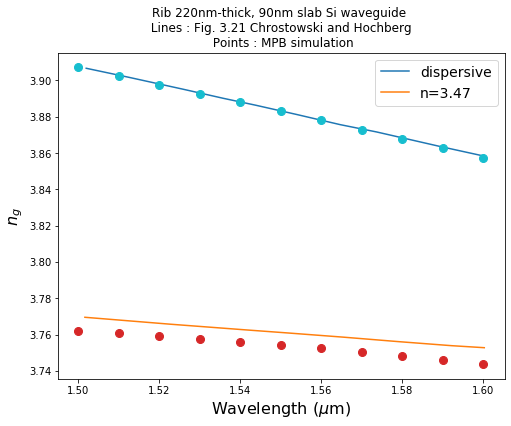

In [28]:
f = plt.figure(figsize=(8, 6))

rib_ng_dispersive_book_TE0 = np.loadtxt('chrostowski_rib_TE0_ng_dispersive.txt', delimiter=',')
rib_ng_fixed_book_TE0 = np.loadtxt('chrostowski_rib_TE0_ng_n3p47.txt', delimiter=',')

plt.plot(rib_ng_dispersive_book_TE0[:,0], rib_ng_dispersive_book_TE0[:,1], label='dispersive', color='tab:blue')
plt.plot(rib_ng_fixed_book_TE0[:,0], rib_ng_fixed_book_TE0[:,1], label='n=3.47', color='tab:orange')

for i in range(11):
    plt.plot(ngs_rib_list[i][0], ngs_rib_list[i][1], marker='o', markersize=8, color='tab:cyan')
    plt.plot(ngs_fixedSi[i][0], ngs_fixedSi[i][1], marker='o', markersize=8, color='tab:red')

plt.xlabel('Wavelength ($\mu$m)', fontsize=16)
plt.ylabel('$n_{g}$', fontsize=16)
plt.title('Rib 220nm-thick, 90nm slab Si waveguide \n Lines : Fig. 3.21 Chrostowski and Hochberg \n Points : MPB simulation')

plt.legend(fontsize=14)

This demonstrates the impact of material dispersion when computing higher order quantities in the band diagram (such as group velocity/index from $\frac{d\omega}{dk}$, dispersion parameter $\sim \frac{d^2\omega}{dk}$, etc.). The finite difference scheme seems to do pretty well for $\beta = 0.001$.